In [1]:
import pandas as pd
import glob
import os

# Set the folder path where your CSV files are stored
folder_path = 'data/output_poses_with_c'  # Adjust if your files are elsewhere

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Load and concatenate all CSV files into one DataFrame
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df['source_file'] = os.path.basename(file)  # Optionally add a column to track source
    df_list.append(df)

all_videos_df = pd.concat(df_list, ignore_index=True)

# Show the first few rows to confirm it worked
print(all_videos_df.head())

# Optionally, save combined DataFrame for later use
# all_videos_df.to_csv('/mnt/data/all_videos_combined.csv', index=False)


   FrameNo  head_x  head_y  head_confidence  left_shoulder_x  left_shoulder_y  \
0        0     995     389         0.557739             1059              450   
1        1     993     389         0.587303             1057              450   
2        2     990     389         0.598732             1057              450   
3        3     988     388         0.613654             1055              452   
4        4     988     388         0.622426             1056              452   

   left_shoulder_confidence  right_shoulder_x  right_shoulder_y  \
0                  0.560603               913               444   
1                  0.557815               913               444   
2                  0.565982               914               444   
3                  0.531750               913               443   
4                  0.534323               916               444   

   right_shoulder_confidence  ...  right_knee_x  right_knee_y  \
0                   0.464795  ...           9

In [18]:
"""
Lowest-confidence pose-sequence finder
• Optional middle-trim
• Full non-overlapping windows only
• Outputs original frame numbers *and* wall-clock time stamps
"""

import pandas as pd
import glob, os, math
from collections import defaultdict

# ─── USER SETTINGS ─────────────────────────────────────────────────────────────
folder_path     = "data/output_poses_with_c"   # where the *.csv live
fps             = 15            # frames per second in the original videos
window_size     = 15            # non-overlapping window size (frames)
list_length     = 200            # total sequences to list
max_per_video   = 1             # cap sequences per individual video
keep_frames     = 45            # keep this many middle frames (None → no trim)
conf_suffix     = "_confidence" # column-name suffix for confidences
# ───────────────────────────────────────────────────────────────────────────────

def fmt_time(sec: float) -> str:
    """Convert decimal seconds to HH:MM:SS (zero-padded, no fractions)."""
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── Trim to middle `keep_frames` if requested ────────────────────────────
    if keep_frames and keep_frames < n_total:
        trim_left  = (n_total - keep_frames) // 2          # floor
        trim_right = n_total - keep_frames - trim_left     # may be +1
        df_trimmed = df.iloc[trim_left : n_total - trim_right].reset_index(drop=True)
    else:
        trim_left  = 0
        df_trimmed = df.copy()

    n_frames = len(df_trimmed)

    # Identify confidence columns
    conf_cols = [c for c in df_trimmed.columns if c.lower().endswith(conf_suffix)]
    if not conf_cols:
        raise ValueError(f"No “{conf_suffix}” columns in {filename}")

    # ── Iterate through *full* non-overlapping windows ───────────────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        start_trim = w * window_size               # 0-based in trimmed clip
        end_trim   = start_trim + window_size      # exclusive
        window     = df_trimmed.iloc[start_trim:end_trim]

        means       = window[conf_cols].mean()
        worst_col   = means.idxmin()
        worst_joint = worst_col.replace(conf_suffix, "")
        worst_val   = means[worst_col]

        # Translate to original frame indices (1-based, inclusive)
        orig_start = trim_left + start_trim + 1
        orig_end   = trim_left + end_trim          # inclusive

        all_windows.append(
            {
                "filename":     filename,
                "orig_start":   orig_start,
                "orig_end":     orig_end,
                "joint":        worst_joint,
                "avg_conf":     worst_val,
                "t_start":      (orig_start - 1) / fps,
                "t_end":        (orig_end   - 1) / fps,
            }
        )

# ─── Global ranking & output limits ───────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])          # worst first
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── Report ───────────────────────────────────────────────────────────────────
print("\nWorst sequences found (original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– confidence of the {w['joint']} is {w['avg_conf']:.2f}"
    )



Worst sequences found (original timeline):

W25.csv  frames 108–122  from 00:00:07 to 00:00:08  – confidence of the left_foot is 0.13
W31.csv  frames 105–119  from 00:00:07 to 00:00:08  – confidence of the right_foot is 0.14
W24.csv  frames 100–114  from 00:00:07 to 00:00:08  – confidence of the left_knee is 0.15
W34.csv  frames 103–117  from 00:00:07 to 00:00:08  – confidence of the left_foot is 0.16
W09.csv  frames 102–116  from 00:00:07 to 00:00:08  – confidence of the right_foot is 0.16
G73.csv  frames 156–170  from 00:00:10 to 00:00:11  – confidence of the right_hand is 0.17
G04.csv  frames 118–132  from 00:00:08 to 00:00:09  – confidence of the right_hand is 0.17
G38.csv  frames 127–141  from 00:00:08 to 00:00:09  – confidence of the right_elbow is 0.17
G28.csv  frames 99–113  from 00:00:07 to 00:00:07  – confidence of the right_hand is 0.17
G05.csv  frames 102–116  from 00:00:07 to 00:00:08  – confidence of the right_hand is 0.18
W18.csv  frames 101–115  from 00:00:07 to 00:00:

In [17]:
"""
Highest-confidence pose-sequence finder
• Optional middle-trim
• Full non-overlapping windows only
• Reports original frame numbers and wall-clock time stamps
• NOW: shows the joint with the HIGHEST confidence in each window
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path     = "data/output_poses_with_c"   # where the *.csv live
fps             = 15            # frames per second in the original videos
window_size     = 10            # non-overlapping window size (frames)
list_length     = 200           # total sequences to list
max_per_video   = 1             # cap sequences per individual video
keep_frames     = 40            # keep this many middle frames (None → no trim)
conf_suffix     = "_confidence" # column-name suffix for confidences
# ──────────────────────────────────────────────────────────────────────────────

def fmt_time(sec: float) -> str:
    """Convert decimal seconds to HH:MM:SS."""
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── Trim to the middle `keep_frames` frames if requested ────────────────
    if keep_frames and keep_frames < n_total:
        trim_left  = (n_total - keep_frames) // 2
        trim_right = n_total - keep_frames - trim_left
        df_trimmed = df.iloc[trim_left : n_total - trim_right].reset_index(drop=True)
    else:
        trim_left  = 0
        df_trimmed = df.copy()

    n_frames   = len(df_trimmed)
    conf_cols  = [c for c in df_trimmed.columns if c.lower().endswith(conf_suffix)]
    if not conf_cols:
        raise ValueError(f"No “{conf_suffix}” columns in {filename}")

    # ── Full, non-overlapping windows ───────────────────────────────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        start_t   = w * window_size
        end_t     = start_t + window_size
        window    = df_trimmed.iloc[start_t:end_t]

        means       = window[conf_cols].mean()
        best_col    = means.idxmax()               # ← change 1 (idxmax, not idxmin)
        best_joint  = best_col.replace(conf_suffix, "")
        best_val    = means[best_col]              # highest = best

        orig_start  = trim_left + start_t + 1      # 1-based inclusive
        orig_end    = trim_left + end_t

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "joint":      best_joint,
                "avg_conf":   best_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── Rank by *highest* joint confidence ──────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"], reverse=True)  # ← change 2
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── Report ──────────────────────────────────────────────────────────────────
print("\nBest sequences found (original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– confidence of the {w['joint']} is {w['avg_conf']:.2f}"
    )



Best sequences found (original timeline):

W08.csv  frames 107–116  from 00:00:07 to 00:00:08  – confidence of the right_hip is 0.79
W29.csv  frames 113–122  from 00:00:07 to 00:00:08  – confidence of the left_hip is 0.75
W06.csv  frames 86–95  from 00:00:06 to 00:00:06  – confidence of the right_shoulder is 0.74
W37.csv  frames 70–79  from 00:00:05 to 00:00:05  – confidence of the left_hip is 0.74
W20.csv  frames 65–74  from 00:00:04 to 00:00:05  – confidence of the right_knee is 0.74
W07.csv  frames 79–88  from 00:00:05 to 00:00:06  – confidence of the right_shoulder is 0.74
G71.csv  frames 239–248  from 00:00:16 to 00:00:16  – confidence of the right_hip is 0.73
W19.csv  frames 60–69  from 00:00:04 to 00:00:05  – confidence of the left_hip is 0.73
G28.csv  frames 92–101  from 00:00:06 to 00:00:07  – confidence of the right_knee is 0.72
G72.csv  frames 261–270  from 00:00:17 to 00:00:18  – confidence of the right_hip is 0.72
W42.csv  frames 95–104  from 00:00:06 to 00:00:07  – confi

FrameNo,
left_shoulder,left_elbow,left_hand, left_hip,left_knee,left_foot,
right_shoulder,right_elbow,right_hand, right_hip,right_knee,right_foot,








Worst sequences found (block averages, original timeline):

A121  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.18
A87  frames 1–30  from 00:00:00 to 00:00:02  – block bottom_left average confidence 0.20
A81  frames 1–30  from 00:00:00 to 00:00:02  – block bottom_left average confidence 0.20
A102  frames 1–30  from 00:00:00 to 00:00:02  – block top_left average confidence 0.20
A100  frames 1–30  from 00:00:00 to 00:00:02  – block bottom_right average confidence 0.21
A118  frames 1–30  from 00:00:00 to 00:00:02  – block top_left average confidence 0.21
A101  frames 1–30  from 00:00:00 to 00:00:02  – block bottom_left average confidence 0.21
A125  frames 1–30  from 00:00:00 to 00:00:02  – block top_left average confidence 0.22
A91  frames 1–30  from 00:00:00 to 00:00:02  – block bottom_right average confidence 0.23
A111  frames 1–30  from 00:00:00 to 00:00:02  – block top_right average confidence 0.23
A84  frames 1–30  from 00:00:00 to 00:00:02  – block 

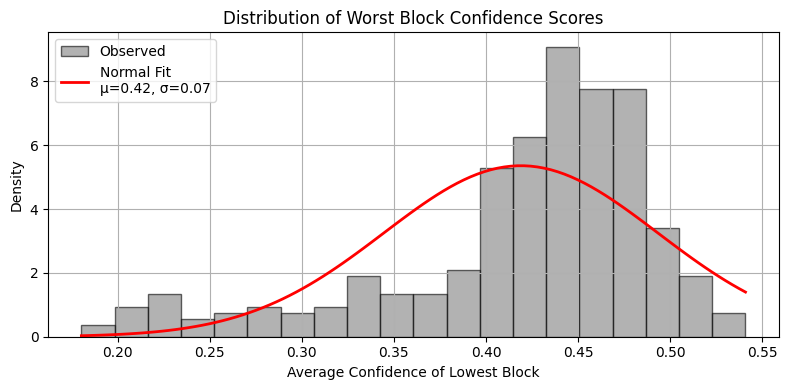


Saved 293 rows to convedence_30.csv



In [23]:
"""
Lowest-confidence pose-sequence finder  (block version)
• Optional middle-trim
• Full non-overlapping windows
• Works with four body blocks (head excluded)
• Reports original frame numbers & hh:mm:ss timeline
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/kinect_good_vs_bad_with_c"  # where the CSVs live
fps           = 15        # frames per second
window_size   = 30        # frames per window (non-overlapping)
list_length   = 5000       # total windows to list
max_per_video = 6         # cap windows per individual video
keep_frames   = 30        # keep this many middle frames (None → no trim)
conf_suffix   = "_confidence"
# ──────────────────────────────────────────────────────────────────────────────

# Map block label → list of confidence column names
BLOCKS = {
    "top_left":    ["left_shoulder_confidence",  "left_elbow_confidence",
                    "left_hand_confidence"],
    "bottom_left": ["left_hip_confidence",       "left_knee_confidence",
                    "left_foot_confidence"],
    "top_right":   ["right_shoulder_confidence", "right_elbow_confidence",
                    "right_hand_confidence"],
    "bottom_right":["right_hip_confidence",      "right_knee_confidence",
                    "right_foot_confidence"],
}

def fmt_time(sec: float) -> str:
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename = os.path.splitext(os.path.basename(path))[0] 
    n_total   = len(df)

    # ── choose the FIRST `keep_frames` frames (no middle-trim any more) ───────────
    if keep_frames and keep_frames < n_total:
        df_trim   = df.iloc[:keep_frames].reset_index(drop=True)   # first X frames
    else:
        df_trim   = df.copy()                                      # use whole clip
    cut_left = 0       # always zero now, because we never trim from the start





    n_frames = len(df_trim)
    # quick sanity: make sure every required column is present
    for cols in BLOCKS.values():
        missing = [c for c in cols if c not in df_trim.columns]
        if missing:
            raise ValueError(f"{filename} lacks columns: {missing}")

    # ── full, non-overlapping windows ───────────────────────────────────────
    for w in range(n_frames // window_size):
        s  = w * window_size
        e  = s + window_size     # exclusive
        win = df_trim.iloc[s:e]

        # block averages for this window
        block_avg = {
            label: win[cols].mean().mean()     # mean over frames then joints
            for label, cols in BLOCKS.items()
        }

        worst_label = min(block_avg, key=block_avg.get)
        worst_val   = block_avg[worst_label]

        orig_start = cut_left + s + 1     # 1-based inclusive
        orig_end   = cut_left + e         # inclusive

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "block":      worst_label,
                "avg_conf":   worst_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── rank & limit output ─────────────────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])  # smallest first  (worst)
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── report ──────────────────────────────────────────────────────────────────
print("\nWorst sequences found (block averages, original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– block {w['block']} average confidence {w['avg_conf']:.2f}"
    )
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract confidence scores from the selected windows
confidences = [w["avg_conf"] for w in selected]

# Fit a normal distribution
mu, std = norm.fit(confidences)

# Generate x-values across the range
x = np.linspace(min(confidences), max(confidences), 100)
pdf = norm.pdf(x, mu, std)

# Plot histogram and fitted normal curve
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed')
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')
plt.title("Distribution of Worst Block Confidence Scores")
plt.xlabel("Average Confidence of Lowest Block")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ─── save results to CSV ──────────────────────────────────────────────────────
if selected:
    out = pd.DataFrame(selected)
    # add hh:mm:ss strings for convenience
    out["t_start_hms"] = out["t_start"].apply(fmt_time)
    out["t_end_hms"]   = out["t_end"].apply(fmt_time)

    output_fname = f"convedence_{window_size}.csv"
    out.to_csv(output_fname, index=False)
    print(f"\nSaved {len(out)} rows to {output_fname}\n")
else:
    print("\nNo windows met the selection criteria – nothing saved.\n")



Worst sequences found (block averages, original timeline):

A97  frames 196–200  from 00:00:13 to 00:00:13  – block bottom_left average confidence 0.10
B16  frames 110–114  from 00:00:07 to 00:00:08  – block top_right average confidence 0.10
B13  frames 155–159  from 00:00:10 to 00:00:11  – block top_left average confidence 0.10
B16  frames 115–119  from 00:00:08 to 00:00:08  – block bottom_right average confidence 0.11
B16  frames 130–134  from 00:00:09 to 00:00:09  – block top_right average confidence 0.11
B15  frames 115–119  from 00:00:08 to 00:00:08  – block bottom_right average confidence 0.11
B11  frames 111–115  from 00:00:07 to 00:00:08  – block top_right average confidence 0.12
B21  frames 102–106  from 00:00:07 to 00:00:07  – block bottom_right average confidence 0.12
B16  frames 125–129  from 00:00:08 to 00:00:09  – block top_right average confidence 0.12
B13  frames 125–129  from 00:00:08 to 00:00:09  – block top_right average confidence 0.12
A157  frames 146–150  from 00

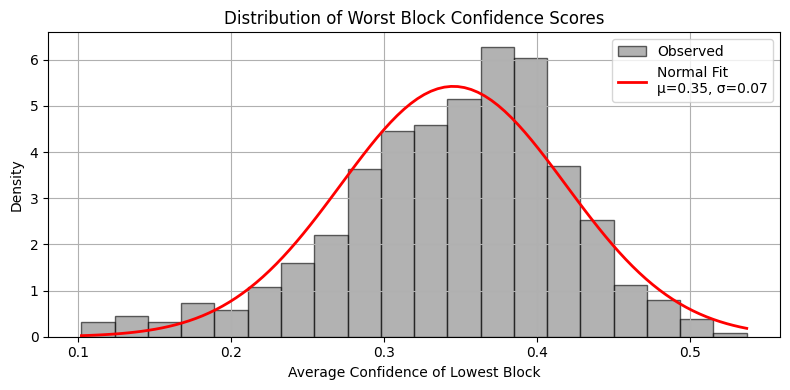


Saved 1758 rows to convedence_5.csv



In [24]:
"""
Lowest-confidence pose-sequence finder  (block version)
• Optional middle-trim
• Full non-overlapping windows
• Works with four body blocks (head excluded)
• Reports original frame numbers & hh:mm:ss timeline
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/kinect_good_vs_bad_with_c"  # where the CSVs live
fps           = 15        # frames per second in the original videos
window_size   = 5        # frames per window (non-overlapping)
list_length   = 5000       # total windows to list
max_per_video = 6         # cap sequences per individual video
keep_frames   = 60        # keep this many middle frames (None → no trim)
conf_suffix   = "_confidence"
# ──────────────────────────────────────────────────────────────────────────────

# Map block label → list of confidence column names
BLOCKS = {
    "top_left":    ["left_shoulder_confidence",  "left_elbow_confidence",
                    "left_hand_confidence"],
    "bottom_left": ["left_hip_confidence",       "left_knee_confidence",
                    "left_foot_confidence"],
    "top_right":   ["right_shoulder_confidence", "right_elbow_confidence",
                    "right_hand_confidence"],
    "bottom_right":["right_hip_confidence",      "right_knee_confidence",
                    "right_foot_confidence"],
}

def fmt_time(sec: float) -> str:
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = filename = os.path.splitext(os.path.basename(path))[0] 
    n_total   = len(df)

    # ── optional middle trim ────────────────────────────────────────────────
    if keep_frames and keep_frames < n_total:
        cut_left  = (n_total - keep_frames) // 2
        cut_right = n_total - keep_frames - cut_left
        df_trim   = df.iloc[cut_left : n_total - cut_right].reset_index(drop=True)
    else:
        cut_left  = 0
        df_trim   = df.copy()

    n_frames = len(df_trim)
    # quick sanity: make sure every required column is present
    for cols in BLOCKS.values():
        missing = [c for c in cols if c not in df_trim.columns]
        if missing:
            raise ValueError(f"{filename} lacks columns: {missing}")

    # ── full, non-overlapping windows ───────────────────────────────────────
    for w in range(n_frames // window_size):
        s  = w * window_size
        e  = s + window_size     # exclusive
        win = df_trim.iloc[s:e]

        # block averages for this window
        block_avg = {
            label: win[cols].mean().mean()     # mean over frames then joints
            for label, cols in BLOCKS.items()
        }

        worst_label = min(block_avg, key=block_avg.get)
        worst_val   = block_avg[worst_label]

        orig_start = cut_left + s + 1     # 1-based inclusive
        orig_end   = cut_left + e         # inclusive

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "block":      worst_label,
                "avg_conf":   worst_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── rank & limit output ─────────────────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])  # smallest first  (worst)
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── report ──────────────────────────────────────────────────────────────────
print("\nWorst sequences found (block averages, original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– block {w['block']} average confidence {w['avg_conf']:.2f}"
    )
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract confidence scores from the selected windows
confidences = [w["avg_conf"] for w in selected]

# Fit a normal distribution
mu, std = norm.fit(confidences)

# Generate x-values across the range
x = np.linspace(min(confidences), max(confidences), 100)
pdf = norm.pdf(x, mu, std)

# Plot histogram and fitted normal curve
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed')
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')
plt.title("Distribution of Worst Block Confidence Scores")
plt.xlabel("Average Confidence of Lowest Block")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ─── save results to CSV ──────────────────────────────────────────────────────
if selected:
    out = pd.DataFrame(selected)
    output_fname = f"convedence_{window_size}.csv"
    out.to_csv(output_fname, index=False)
    print(f"\nSaved {len(out)} rows to {output_fname}\n")
else:
    print("\nNo windows met the selection criteria – nothing saved.\n")


Most-jittery sequences found:

B18  frames 104–108  from 00:00:07 to 00:00:07  – block top_left total displacement 7329.4 units
A121  frames 96–100  from 00:00:06 to 00:00:07  – block top_left total displacement 6107.2 units
B19  frames 104–108  from 00:00:07 to 00:00:07  – block top_left total displacement 5612.5 units
B21  frames 107–111  from 00:00:07 to 00:00:07  – block top_left total displacement 4889.4 units
B20  frames 110–114  from 00:00:07 to 00:00:08  – block top_left total displacement 4532.1 units
A108  frames 145–149  from 00:00:10 to 00:00:10  – block top_right total displacement 3977.4 units
B18  frames 114–118  from 00:00:08 to 00:00:08  – block top_left total displacement 3716.4 units
B7  frames 124–128  from 00:00:08 to 00:00:08  – block top_left total displacement 3687.3 units
B19  frames 109–113  from 00:00:07 to 00:00:07  – block top_left total displacement 3532.6 units
B21  frames 112–116  from 00:00:07 to 00:00:08  – block top_left total displacement 3523.3 uni

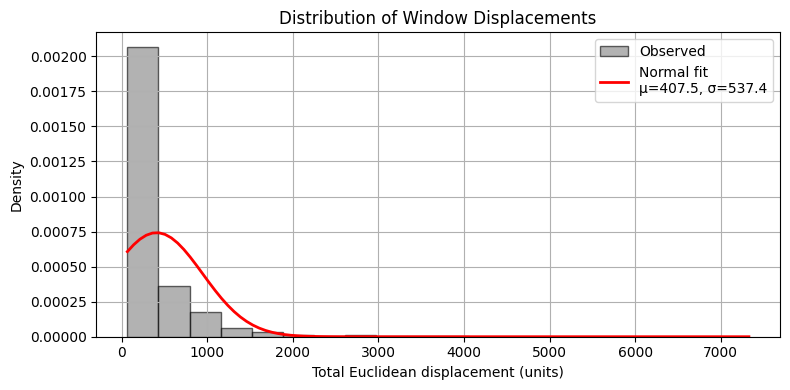


Saved 1758 rows to 'motion_5.csv'.


In [25]:
"""
Most-jittery pose-sequence finder  (4-block version)
• Keeps only the middle `keep_frames` frames of every clip (optional)
• Splits those frames into full, non-overlapping windows
• For each window, measures total x-y displacement inside each of the
  four body blocks (head excluded)
• Ranks windows by the **largest** block displacement (i.e. most “stutter”)
• Reports timeline info, plots the displacement distribution, and
  saves the results to CSV
"""

import pandas as pd
import numpy as np
import glob, os
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import norm

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/kinect_good_vs_bad_with_c"   # where the CSV files live
fps           = 15        # frames per second in the original videos
window_size   = 5        # frames per window (non-overlapping)
list_length   = 5000       # total windows to list
max_per_video = 6         # cap sequences per individual video
keep_frames   = 60        # keep this many middle frames (None → no trim)
out_csv_name  = f"motion_{window_size}.csv"  # output file name
# ──────────────────────────────────────────────────────────────────────────────

# Four body blocks (no head)
BLOCKS = {
    "top_left":    ["left_shoulder",  "left_elbow",  "left_hand"],
    "bottom_left": ["left_hip",       "left_knee",   "left_foot"],
    "top_right":   ["right_shoulder", "right_elbow", "right_hand"],
    "bottom_right":["right_hip",      "right_knee",  "right_foot"],
}

def fmt_time(sec: float) -> str:
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

# ─── iterate through every video CSV ──────────────────────────────────────────
for path in csv_files:
    df        = pd.read_csv(path)
    filename  = filename = os.path.splitext(os.path.basename(path))[0] 
    n_total   = len(df)

    # ── keep the middle `keep_frames` frames if requested ────────────────────
    if keep_frames and keep_frames < n_total:
        cut_left  = (n_total - keep_frames) // 2
        cut_right = n_total - keep_frames - cut_left
        df_trim   = df.iloc[cut_left : n_total - cut_right].reset_index(drop=True)
    else:
        cut_left  = 0
        df_trim   = df.copy()

    n_frames = len(df_trim)

    # ── full, non-overlapping windows ranked by motion “jitter” ──────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        s, e = w * window_size, (w + 1) * window_size      # [s, e)
        win  = df_trim.iloc[s:e]

        block_disp = {}
        for label, joints in BLOCKS.items():
            xy_cols = []
            for j in joints:
                xy_cols.extend([f"{j}_x", f"{j}_y"])

            # Ensure columns exist
            missing = [c for c in xy_cols if c not in win.columns]
            if missing:
                raise ValueError(f"{filename} is missing columns: {missing}")

            # frame-to-frame deltas
            diffs = win[xy_cols].diff().iloc[1:]            # drop first NaN
            if diffs.empty:
                continue
            arr   = diffs.to_numpy().reshape(len(diffs), -1, 2)  # (F-1, J, 2)
            dist  = np.linalg.norm(arr, axis=2)             # Euclidean per joint/frame
            block_disp[label] = dist.sum()                  # scalar displacement

        # find block with max displacement (= most jitter)
        worst_label = max(block_disp, key=block_disp.get)
        worst_val   = block_disp[worst_label]

        orig_start  = cut_left + s + 1     # 1-based inclusive
        orig_end    = cut_left + e         # inclusive

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "block":      worst_label,
                "motion":     worst_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── rank & limit output ─────────────────────────────────────────────────────
all_windows.sort(key=lambda w: w["motion"], reverse=True)   # largest first
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── report ──────────────────────────────────────────────────────────────────
print("\nMost-jittery sequences found:\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– block {w['block']} total displacement {w['motion']:.1f} units"
    )

# ─── distribution plot ───────────────────────────────────────────────────────
if selected:
    motions = [w["motion"] for w in selected]
    mu, std = norm.fit(motions)
    xs      = np.linspace(min(motions), max(motions), 100)
    pdf     = norm.pdf(xs, mu, std)

    plt.figure(figsize=(8, 4))
    plt.hist(motions, bins=20, density=True, alpha=0.6,
             color='gray', edgecolor='black', label='Observed')
    plt.plot(xs, pdf, 'r-', linewidth=2,
             label=f'Normal fit\nμ={mu:.1f}, σ={std:.1f}')
    plt.title("Distribution of Window Displacements")
    plt.xlabel("Total Euclidean displacement (units)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ─── save results to CSV ──────────────────────────────────────────────────────
if selected:
    out = pd.DataFrame(selected)
    out.to_csv(out_csv_name, index=False)
    print(f"\nSaved {len(out)} rows to '{out_csv_name}'.")
else:
    print("\nNo windows met the selection criteria – nothing saved.")



Jitter scores by video (highest → lowest):

B21                        jitter=  335193.2  (262 frames ≈ 00:00:17)
B16                        jitter=  311612.8  (269 frames ≈ 00:00:18)
B22                        jitter=  301285.7  (240 frames ≈ 00:00:16)
B18                        jitter=  277633.5  (267 frames ≈ 00:00:18)
A81                        jitter=  253110.7  (326 frames ≈ 00:00:22)
B20                        jitter=  249653.9  (259 frames ≈ 00:00:17)
B19                        jitter=  196446.3  (256 frames ≈ 00:00:17)
B14                        jitter=  189118.2  (273 frames ≈ 00:00:18)
B6                         jitter=  180353.9  (337 frames ≈ 00:00:22)
A87                        jitter=  180170.1  (296 frames ≈ 00:00:20)
B15                        jitter=  172257.5  (269 frames ≈ 00:00:18)
A104                       jitter=  171405.3  (198 frames ≈ 00:00:13)
A157                       jitter=  159027.7  (251 frames ≈ 00:00:17)
B12                        jitter=  154331.6 

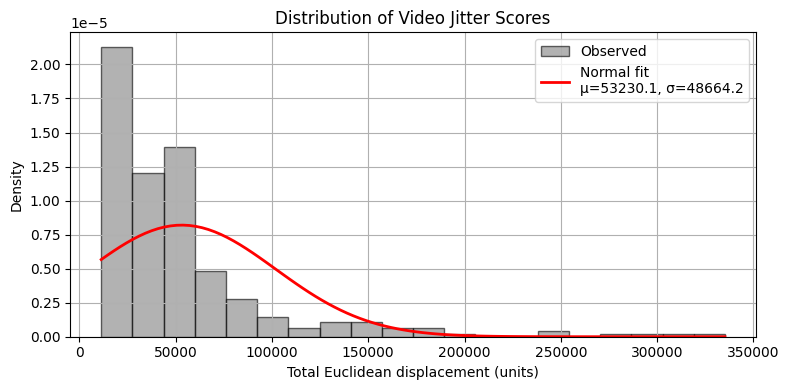


Saved scores for 293 videos to “video_jitter_scores.csv”.


In [26]:
"""
Whole-video “jitter” scorer (no trimming, no blocks)
• Reads every pose-CSV in `folder_path`
• Uses **all *_x and *_y columns** (head included, nothing excluded)
• Computes total Euclidean displacement of every joint over the entire clip
• One scalar jitter score per video = sum of all joint displacements
• Prints a ranking, plots the distribution, and saves results to CSV
"""

import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from scipy.stats import norm

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path  = "data/kinect_good_vs_bad_with_c"   # where the CSVs live
fps          = 15                                 # frames per second (for info)
out_csv_name = "video_jitter_scores.csv"          # output file
# ──────────────────────────────────────────────────────────────────────────────

def fmt_time(sec: float) -> str:
    h, m = divmod(int(round(sec)), 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in “{folder_path}”")

records = []

# ─── per-video loop ───────────────────────────────────────────────────────────
for path in csv_files:
    df       = pd.read_csv(path)
    fname    = os.path.splitext(os.path.basename(path))[0]   # strip “.csv”
    n_frames = len(df)

    # discover every (x,y) coordinate pair
    x_cols = [c for c in df.columns if c.endswith("_x")]
    pairs  = [(c, c[:-2] + "_y") for c in x_cols if c[:-2] + "_y" in df.columns]
    if not pairs:
        raise ValueError(f"{fname}: no *_x/_y coordinate pairs detected")

    # frame-to-frame deltas for all coords
    all_xy_cols = [c for pair in pairs for c in pair]
    diffs = df[all_xy_cols].diff().iloc[1:]                 # drop first NaN row
    if diffs.empty:                                         # single-frame clip
        total_disp = 0.0
    else:
        arr  = diffs.to_numpy().reshape(len(diffs), -1, 2)  # (F-1, J, 2)
        dist = np.linalg.norm(arr, axis=2)                  # Euclidean per joint/frame
        total_disp = dist.sum()

    records.append(
        {
            "filename":     fname,
            "jitter_score": total_disp,
            "num_frames":   n_frames,
            "clip_len_sec": n_frames / fps,
        }
    )

# ─── results dataframe ───────────────────────────────────────────────────────
results = pd.DataFrame(records).sort_values("jitter_score", ascending=False)

print("\nJitter scores by video (highest → lowest):\n")
for _, r in results.iterrows():
    print(f"{r.filename:<25s}  jitter={r.jitter_score:10.1f}  "
          f"({r.num_frames} frames ≈ {fmt_time(r.clip_len_sec)})")

# ─── distribution plot ───────────────────────────────────────────────────────
if not results.empty:
    js  = results["jitter_score"].values
    mu, std = norm.fit(js)
    xs  = np.linspace(js.min(), js.max(), 100)
    pdf = norm.pdf(xs, mu, std)

    plt.figure(figsize=(8, 4))
    plt.hist(js, bins=20, density=True, alpha=0.6,
             color="gray", edgecolor="black", label="Observed")
    plt.plot(xs, pdf, "r-", linewidth=2,
             label=f"Normal fit\nμ={mu:.1f}, σ={std:.1f}")
    plt.title("Distribution of Video Jitter Scores")
    plt.xlabel("Total Euclidean displacement (units)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ─── save to CSV ─────────────────────────────────────────────────────────────
results.to_csv(out_csv_name, index=False)
print(f"\nSaved scores for {len(results)} videos to “{out_csv_name}”.")


In [27]:
import pandas as pd
import numpy as np

# ─── load the jitter file ─────────────────────────────────────────────────────
in_csv  = "video_jitter_scores.csv"
out_csv = "video_jitter_scores_labeled.csv"

df = pd.read_csv(in_csv)

# ─── order by jitter (least → greatest) ───────────────────────────────────────
df = df.sort_values("jitter_score", ascending=True).reset_index(drop=True)

# ─── create 5 equal-sized bins ───────────────────────────────────────────────
n          = len(df)
base_size  = n // 5                # rows per bin if divisible by 5
remainder  = n % 5                 # extra rows that can’t be evenly split

# build an array like [0,0,…,1,1,…,4,4]
bin_ids = np.repeat(np.arange(5), base_size)
# tack on the remainder rows (they’ll go to the “best” side)
if remainder:
    bin_ids = np.concatenate([bin_ids, np.arange(remainder)])

# map to goodness scores (invert so bin 0 → 5, bin 4 → 1)
goodness = 5 - bin_ids[:n]
df["goodness"] = goodness

# ─── save & quick sanity print ───────────────────────────────────────────────
df.to_csv(out_csv, index=False)
print(f"Saved {len(df)} rows with goodness scores to “{out_csv}”.")
print(df.head())      # peek at the best few
print(df.tail())      # …and the worst few


Saved 293 rows with goodness scores to “video_jitter_scores_labeled.csv”.
  filename  jitter_score  num_frames  clip_len_sec  goodness
0     A136  11413.682645         127      8.466667         5
1     A132  12389.987682         146      9.733333         5
2      A95  12812.382859         180     12.000000         5
3      A92  12837.379683         124      8.266667         5
4     A131  13146.580654         169     11.266667         5
    filename   jitter_score  num_frames  clip_len_sec  goodness
288      A81  253110.696994         326     21.733333         1
289      B18  277633.474363         267     17.800000         1
290      B22  301285.742471         240     16.000000         5
291      B16  311612.833652         269     17.933333         4
292      B21  335193.213711         262     17.466667         3



Confidence scores by video (highest → lowest):

filename  confidence_score
    A140          0.577418
    A142          0.566663
    A144          0.560889
    A141          0.559436
    A139          0.558681
     A15          0.558192
     A28          0.554180
    A147          0.554150
     A42          0.553189
     A41          0.552845
    A146          0.551512
      B5          0.551030
    A143          0.550565
    A145          0.549235
      A3          0.548417
     A26          0.548311
    A148          0.546383
    A137          0.545346
      B4          0.543563
     A27          0.542736
      A1          0.541481
      A9          0.540886
     A67          0.540851
     A17          0.539817
     A16          0.539196
     A34          0.538407
     A43          0.538337
     A69          0.538170
    A138          0.536840
     A37          0.536693
     A36          0.536046
      A4          0.534965
     A29          0.534831
     A18          0.534668
     A

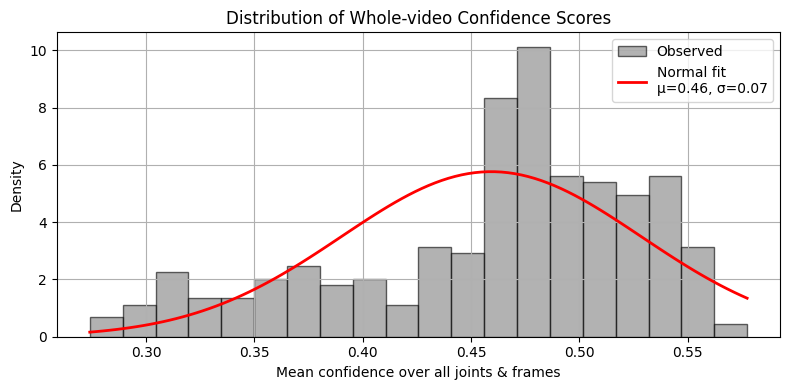


Saved 293 rows to “video_confidence_scores.csv”.


In [28]:
"""
Whole-video confidence scorer
• Reads every pose-CSV in `folder_path`
• Uses **every *_confidence column**, including the single `pose_confidence`
  column, across *all* frames
• Aggregates them into **one scalar confidence score per video**:
      score = simple arithmetic mean of all confidence values
  (change to .median(), .min(), etc. if you prefer)
• Ranks videos (highest confidence first), plots the distribution,
  and saves results to CSV
"""

import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from scipy.stats import norm

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path  = "data/kinect_good_vs_bad_with_c"   # where the CSVs live
out_csv_name = "video_confidence_scores.csv"      # output file name
# ──────────────────────────────────────────────────────────────────────────────

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in “{folder_path}”")

records = []

for path in csv_files:
    df       = pd.read_csv(path)
    fname    = os.path.splitext(os.path.basename(path))[0]   # strip ".csv"

    # pick every column that ends with "_confidence" *plus* "pose_confidence"
    conf_cols = [c for c in df.columns if c.endswith("_confidence")] + ["pose_confidence"]
    conf_cols = [c for c in conf_cols if c in df.columns]   # keep only existing ones

    if not conf_cols:
        raise ValueError(f"{fname}: no confidence columns detected")

    agg_conf = df[conf_cols].mean().mean()   # mean over frames, then columns
    records.append({"filename": fname, "confidence_score": agg_conf})

# assemble results
results = pd.DataFrame(records).sort_values("confidence_score", ascending=False)

print("\nConfidence scores by video (highest → lowest):\n")
print(results.to_string(index=False))

# ─── distribution plot ───────────────────────────────────────────────────────
scores = results["confidence_score"].values
mu, std = norm.fit(scores)
xs  = np.linspace(scores.min(), scores.max(), 100)
pdf = norm.pdf(xs, mu, std)

plt.figure(figsize=(8, 4))
plt.hist(scores, bins=20, density=True, alpha=0.6,
         color="gray", edgecolor="black", label="Observed")
plt.plot(xs, pdf, "r-", linewidth=2,
         label=f"Normal fit\nμ={mu:.2f}, σ={std:.2f}")
plt.title("Distribution of Whole-video Confidence Scores")
plt.xlabel("Mean confidence over all joints & frames")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── save to CSV ─────────────────────────────────────────────────────────────
results.to_csv(out_csv_name, index=False)
print(f"\nSaved {len(results)} rows to “{out_csv_name}”.")


In [29]:
import pandas as pd
import sys, os

# ─── file names ───────────────────────────────────────────────────────────────
jitter_csv   = "video_jitter_scores_labeled.csv"
conf_csv     = "video_confidence_scores.csv"
out_csv      = "merged_video_scores.csv"

# ─── load the two tables ──────────────────────────────────────────────────────
try:
    jitter_df = pd.read_csv(jitter_csv, usecols=["filename", "goodness"])
except ValueError:
    sys.exit(f"❌ '{jitter_csv}' must have columns: filename, goodness")

try:
    conf_df   = pd.read_csv(conf_csv,   usecols=["filename", "confidence_score"])
except ValueError:
    sys.exit(f"❌ '{conf_csv}' must have columns: filename, confidence_score")

# ─── merge on ‘filename’ ──────────────────────────────────────────────────────
merged = pd.merge(jitter_df, conf_df, on="filename", how="inner")

if merged.empty:
    sys.exit("❌ No matching filenames between the two CSVs; nothing to save.")

# ─── save & report ───────────────────────────────────────────────────────────
merged.to_csv(out_csv, index=False)
print(f"✅ Merged {len(merged)} rows -> '{out_csv}'.")
print(merged.head())        # quick peek


✅ Merged 293 rows -> 'merged_video_scores.csv'.
  filename  goodness  confidence_score
0     A136         5          0.476837
1     A132         5          0.464345
2      A95         5          0.462129
3      A92         5          0.430011
4     A131         5          0.469573


Pearson r = 0.614,   p-value = 8.656e-32


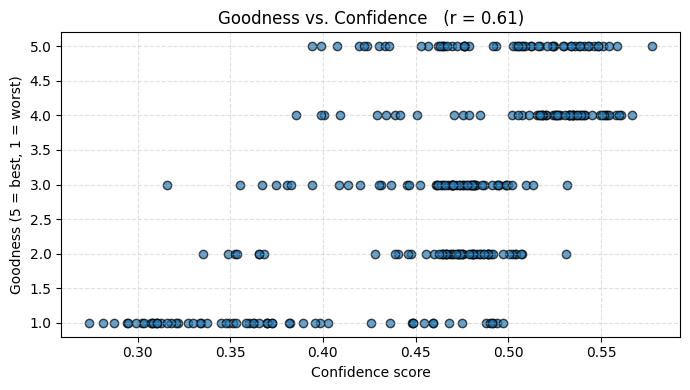

In [30]:
"""
Scatter-plot and correlation between
    • confidence_score
    • goodness
using the merged CSV produced previously.
"""

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ─── file to load ─────────────────────────────────────────────────────────────
merged_csv = "merged_video_scores.csv"      # contains: filename, goodness, confidence_score
df = pd.read_csv(merged_csv)

# ─── correlation ──────────────────────────────────────────────────────────────
r, p = pearsonr(df["confidence_score"], df["goodness"])
print(f"Pearson r = {r:.3f},   p-value = {p:.4g}")

# ─── scatter plot ────────────────────────────────────────────────────────────
plt.figure(figsize=(7, 4))
plt.scatter(df["confidence_score"], df["goodness"], alpha=0.7, edgecolor="black")
plt.title(f"Goodness vs. Confidence   (r = {r:.2f})")
plt.xlabel("Confidence score")
plt.ylabel("Goodness (5 = best, 1 = worst)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
